In [1]:
# import libraries
import numpy as np
import pandas as pd #to work with csv files

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

#pre-processing imports
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from string import punctuation

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split

#pre-processing of text
import string
import re

#import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

#import time function from time module to track the training duration
from time import time

from gensim.models import Word2Vec, KeyedVectors

from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import re
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet, stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, PCA, TruncatedSVD, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from bs4 import BeautifulSoup as bs
from nltk.util import ngrams
import cgi
import nltk
import html
#import readability 
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michaellewis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaellewis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaellewis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# useful function
def filter_president(President):
    filtered = tweets[tweets['author'] == President]
    return filtered

In [3]:
# Import data and concatenate 
biden = pd.read_csv("biden_filtered.csv")
trump = pd.read_csv("trump_filtered.csv")
biden['author'] = "Biden"
trump['author'] = "Trump"

trump = trump[trump.columns[1:]]
biden = biden[biden.columns[1:]]

tweets = pd.concat([biden, trump])

In [4]:
# Cleaning class
class TwitterCleaner:
    def __init__(self, df, column):
        self.df = df
        self.column = column

    def decode_xml_entities(self, text):
        text = html.unescape(text)
        text = str(text)
        return text

    def clean_text(self, lemmatize=False, stem=False, remove_stopwords=True):
        stop_words = set(stopwords.words('english'))
        self.df[self.column] = self.df[self.column].apply(lambda x: str(x))
        clean_list = []
        for text in self.df[self.column]:
            # remove URLs
            text = re.sub(r'http\S+','', text)  

            # remove '@' twitter mentions
            text = re.sub(r'@[A-Za-z0-9_]+','', text) 

            # XML to characters
            text = self.decode_xml_entities(text)

            # lowercase the text
            text = text.lower() 
            words = word_tokenize(text)

            clean_words = []

            # stemming / lemmatization

            for word in words:
                if remove_stopwords == True and word in stop_words:
                    continue
                if lemmatize == True: 
                    lemmatizer = WordNetLemmatizer()
                    word = lemmatizer.lemmatize(word)
                if stem == True: 
                    stemmer = PorterStemmer()
                    word = stemmer.stem(word)
                clean_words.append(word)

            clean_text = ' '.join(clean_words)
            clean_list.append(clean_text)

        if lemmatize:
            if remove_stopwords:
                self.df[f"{self.column}_clean_lemmatized_stopwords"] = clean_list
            else:
                self.df[f"{self.column}_clean_lemmatized"] = clean_list
        elif stem:
            if remove_stopwords:
                self.df[f"{self.column}_clean_stemmed_stopwords"] = clean_list
            else:
                self.df[f"{self.column}_clean_stemmed"] = clean_list
        else:
            if remove_stopwords:
                self.df[f"{self.column}_clean_stopwords"] = clean_list
            else:
                self.df[f"{self.column}_clean"] = clean_list

        return self.df

In [5]:
tc = TwitterCleaner(tweets, 'text')
tweets = tc.clean_text(lemmatize = False, stem = False, remove_stopwords = False)
tweets

,text,likes,retweets,timestamp,id,author,text_clean
0,Every single human being deserves to be treate...,11574,2423,2020-01-01 18:35:00,1.212442e+18,Biden,every single human being deserves to be treate...
1,With just over one month until the Iowa Caucus...,1457,368,2020-01-02 00:01:00,1.212524e+18,Biden,with just over one month until the iowa caucus...
2,This election is about the soul of our nation ...,44886,10192,2020-01-02 01:05:00,1.212540e+18,Biden,this election is about the soul of our nation ...
3,Every day that Donald Trump remains in the Whi...,9581,2005,2020-01-02 02:07:00,1.212556e+18,Biden,every day that donald trump remains in the whi...
4,It was a privilege to work with @JulianCastro ...,17156,2284,2020-01-02 16:10:00,1.212768e+18,Biden,it was a privilege to work with during the oba...
...,...,...,...,...,...,...,...
6403,"Iran never won a war, but never lost a negotia...",303007,57253,2020-01-03 12:44:30,1.213079e+18,Trump,"iran never won a war , but never lost a negoti..."
6404,Thank you to the @dcexaminer Washington Examin...,35044,9213,2020-01-01 01:03:15,1.212177e+18,Trump,thank you to the washington examiner . the lis...
6405,One of my greatest honors was to have gotten C...,56731,12761,2020-01-01 00:55:01,1.212175e+18,Trump,one of my greatest honors was to have gotten c...
6406,Just signed an order to support the workers of...,176289,36001,2020-10-22 21:04:21,1.319384e+18,Trump,just signed an order to support the workers of...


In [6]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
    # function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity
# function to analyze polarity scores
def analysis(score):
    if score < 0:
        return 0 #Negative 
    else:
        return 1 #Positive

In [7]:
tweets['Subjectivity'] = tweets['text_clean'].apply(getSubjectivity) 
tweets['Polarity'] = tweets['text_clean'].apply(getPolarity) 
tweets['Analysis'] = tweets['Polarity'].apply(analysis)
tweets

,text,likes,retweets,timestamp,id,author,text_clean,Subjectivity,Polarity,Analysis
0,Every single human being deserves to be treate...,11574,2423,2020-01-01 18:35:00,1.212442e+18,Biden,every single human being deserves to be treate...,0.452381,-0.295238,0
1,With just over one month until the Iowa Caucus...,1457,368,2020-01-02 00:01:00,1.212524e+18,Biden,with just over one month until the iowa caucus...,0.000000,0.000000,1
2,This election is about the soul of our nation ...,44886,10192,2020-01-02 01:05:00,1.212540e+18,Biden,this election is about the soul of our nation ...,0.000000,0.000000,1
3,Every day that Donald Trump remains in the Whi...,9581,2005,2020-01-02 02:07:00,1.212556e+18,Biden,every day that donald trump remains in the whi...,0.075000,0.033333,1
4,It was a privilege to work with @JulianCastro ...,17156,2284,2020-01-02 16:10:00,1.212768e+18,Biden,it was a privilege to work with during the oba...,0.516667,0.350000,1
...,...,...,...,...,...,...,...,...,...,...
6403,"Iran never won a war, but never lost a negotia...",303007,57253,2020-01-03 12:44:30,1.213079e+18,Trump,"iran never won a war , but never lost a negoti...",0.000000,0.000000,1
6404,Thank you to the @dcexaminer Washington Examin...,35044,9213,2020-01-01 01:03:15,1.212177e+18,Trump,thank you to the washington examiner . the lis...,0.000000,0.000000,1
6405,One of my greatest honors was to have gotten C...,56731,12761,2020-01-01 00:55:01,1.212175e+18,Trump,one of my greatest honors was to have gotten c...,0.683333,0.391667,1
6406,Just signed an order to support the workers of...,176289,36001,2020-10-22 21:04:21,1.319384e+18,Trump,just signed an order to support the workers of...,0.260317,-0.026786,0


**Topoic Modeling**

In [8]:
# Topic modeling for all tweets
tfidf_vect = TfidfVectorizer(min_df = 20, stop_words = 'english')
doc_term_matrix = tfidf_vect.fit_transform(tweets.text_clean.values.astype('U')) # unicode characters

import warnings
warnings.filterwarnings("ignore")
# code derived from: https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8

def display_topics(model, feature_names, num_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

# define non-negative matrix factorization set to 5 components
nmf_model = NMF(10)
# apply to document term matrix
doc_topics = nmf_model.fit_transform(doc_term_matrix)
# results 
display_topics(nmf_model, tfidf_vect.get_feature_names_out(), 5)



Topic  0
thank, maga, kag2020, pennsylvania, florida

Topic  1
election, people, just, big, country

Topic  2
great, job, honor, book, state

Topic  3
news, fake, media, conference, white

Topic  4
endorsement, complete, total, amendment, second

Topic  5
vote, today, early, ballot, head

Topic  6
biden, joe, sleepy, left, china

Topic  7
america, make, united, sure, going

Topic  8
trump, donald, nation, white, house

Topic  9
president, need, care, ll, health


In [9]:
doc_term_matrix.shape

(9335, 1045)

In [10]:
# Only Biden
tfidf_vect = TfidfVectorizer(min_df = 10, stop_words = 'english')
biden = filter_president("Biden")
doc_term_matrix = tfidf_vect.fit_transform(biden.text_clean.values.astype('U'))

# Topic modeling for all tweets

import warnings
warnings.filterwarnings("ignore")
# code derived from: https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8

def display_topics(model, feature_names, num_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

# define non-negative matrix factorization set to 5 components
nmf_model = NMF(10)
# apply to document term matrix
doc_topics = nmf_model.fit_transform(doc_term_matrix)
# results 
display_topics(nmf_model, tfidf_vect.get_feature_names_out(), 5)


Topic  0
president, need, mr, ll, trump

Topic  1
vote, today, make, early, head

Topic  2
trump, donald, failed, beat, lead

Topic  3
america, better, future, build, united

Topic  4
care, health, access, workers, affordable

Topic  5
help, chip, campaign, going, days

Topic  6
tune, covid, 19, watch, live

Topic  7
thank, support, fight, lines, doing

Topic  8
american, people, know, crisis, ve

Topic  9
nation, white, house, let, soul


In [11]:
# Only Trump
tfidf_vect = TfidfVectorizer(min_df = 10, stop_words = 'english')
trump = filter_president("Trump")
doc_term_matrix = tfidf_vect.fit_transform(trump.text_clean.values.astype('U'))

# Topic modeling for all tweets

import warnings
warnings.filterwarnings("ignore")
# code derived from: https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8

def display_topics(model, feature_names, num_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

# define non-negative matrix factorization set to 5 components
nmf_model = NMF(10)
# apply to document term matrix
doc_topics = nmf_model.fit_transform(doc_term_matrix)
# results 
display_topics(nmf_model, tfidf_vect.get_feature_names_out(), 5)


Topic  0
thank, kag2020, michigan, approval, honor

Topic  1
great, job, honor, book, state

Topic  2
biden, joe, president, sleepy, trump

Topic  3
total, complete, endorsement, amendment, second

Topic  4
news, fake, media, lamestream, big

Topic  5
election, rigged, won, ballots, fraud

Topic  6
america, make, vote, going, great

Topic  7
true, thanks, fraud, getting, obamagate

Topic  8
00, conference, house, white, enjoy

Topic  9
maga, pennsylvania, soon, vote, way


**Using Word2vec word embeddings to predict positive or negative sentiment with Logistic Regression and SVC**

In [12]:
# Use word2vec to predict the positive or negative sentiment

X = tweets['text_clean']
y = tweets['Analysis']
print(len(X), len(y))

9335 9335


In [13]:
# Vectorize

class word2vecVectorizer:
    
    def __init__(self):

        word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
        self.word2vec = word2vec

    def fit(self, data, *args):
        pass

    def transform(self, data, *args):
        DIMENSION = 300
        X = np.zeros((len(data), DIMENSION))
        n = 0
        emptycount = 0
        for tokens in data:
            vecs = []
            for token in tokens:
                if token in self.word2vec:
                    vec = self.word2vec[token]
                    vecs.append(vec)
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount +=1
            n +=1
        #print("Number of samples with no words found / total: %s / %s" % (emptycount, len(data))) 
        return X

    def fit_transform(self, X, *args):
        self.fit(X, *args)
        return self.transform(X, *args)
    
vect = word2vecVectorizer()

In [14]:
X = vect.fit_transform(X)
print(X.shape)
print(y.shape)

(9335, 300)
(9335,)


In [15]:
# Predict Sentiment
word2vec_pipe = Pipeline([('estimator', SVC())])

# split data 
x_train, x_test, y_train, y_test = train_test_split(X, 
y, test_size = .25, random_state = 23)

In [16]:
# create a parameter grid
param_grid = [{'estimator' : [LogisticRegression()], 
               'estimator__C' : np.logspace(-3, 3, 7)},
              {'estimator' : [SVC(kernel = "linear")], 
               'estimator__C' : np.logspace(-2, 2, 4), 
               'estimator__gamma' : np.logspace(-2, 2, 5) / X.shape[0]},
               {'estimator' : [SVC(kernel="sigmoid")], 
               'estimator__C' : np.logspace(-2, 2, 4), 
               'estimator__gamma' : np.logspace(-2, 2, 5) / X.shape[0]}
             ]   

# create a RandomizedSearchCV object
word2vec_grid_search = GridSearchCV(
    estimator = word2vec_pipe,
    param_grid = param_grid,
    scoring = 'accuracy',
    n_jobs = -1,
    refit= True, 
    verbose = 1,
    return_train_score = True
)

# fit RandomizedSearchCV object
word2vec_grid_search.fit(x_train, y_train)

# print grid search results
cols = ['param_estimator',
        'param_estimator__C',
        'param_estimator__gamma',
        'mean_test_score',
        'mean_train_score']

pd.options.display.max_colwidth = 50

word2vec_grid_search_results = pd.DataFrame(word2vec_grid_search.cv_results_).sort_values(by = 'mean_test_score', 
                                                                                          ascending = False)
word2vec_grid_search_results[cols]

Fitting 5 folds for each of 47 candidates, totalling 235 fits


,param_estimator,param_estimator__C,param_estimator__gamma,mean_test_score,mean_train_score
0,LogisticRegression(C=0.001),0.001,NaN,0.810027,0.810027
35,SVC(kernel='sigmoid'),0.215443,0.001071,0.810027,0.810027
26,SVC(kernel='linear'),100.0,0.010712,0.810027,0.810027
27,SVC(kernel='sigmoid'),0.01,0.000001,0.810027,0.810027
28,SVC(kernel='sigmoid'),0.01,0.000011,0.810027,0.810027
29,SVC(kernel='sigmoid'),0.01,0.000107,0.810027,0.810027
30,SVC(kernel='sigmoid'),0.01,0.001071,0.810027,0.810027
31,SVC(kernel='sigmoid'),0.01,0.010712,0.810027,0.810027
32,SVC(kernel='sigmoid'),0.215443,0.000001,0.810027,0.810027
33,SVC(kernel='sigmoid'),0.215443,0.000011,0.810027,0.810027


In [17]:
pred = word2vec_grid_search.predict(x_test)
confusion_matrix(y_test, pred)

array([[   0,  424],
       [   0, 1910]])

In [18]:
target_names = ['Negative', 'Positive']
print(classification_report(y_test, pred, target_names = target_names)) #unbalanced dataset

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       424
    Positive       0.82      1.00      0.90      1910

    accuracy                           0.82      2334
   macro avg       0.41      0.50      0.45      2334
weighted avg       0.67      0.82      0.74      2334



**Subjectivity Over Time**

In [19]:
def filter_president(President):
    filtered = tweets[tweets['author'] == President]
    return filtered

print("Biden Subjectivity Mean: " + str(filter_president('Biden').Subjectivity.mean()))
print("Trump Subjectivity Mean: " + str(filter_president('Trump').Subjectivity.mean()))

biden = filter_president("Biden")
trump = filter_president("Trump")

Biden Subjectivity Mean: 0.35475767245378376
Trump Subjectivity Mean: 0.3816032878478396


In [20]:
biden_monthly_subjectivity = biden.groupby(pd.PeriodIndex(biden['timestamp'], freq="M"))['Subjectivity'].mean() 
trump_monthly_subjectivity = trump.groupby(pd.PeriodIndex(trump['timestamp'], freq="M"))['Subjectivity'].mean()

timestamp
2020-01    0.444377
2020-02    0.386379
2020-03    0.337467
2020-04    0.361409
2020-05    0.349735
2020-06    0.363501
2020-07    0.347916
2020-08    0.363099
2020-09    0.317042
2020-10    0.332317
2020-11    0.248330
Freq: M, Name: Subjectivity, dtype: float64


Text(0.5, 1.0, 'Average Monthly Subjectivity, Biden Tweets')

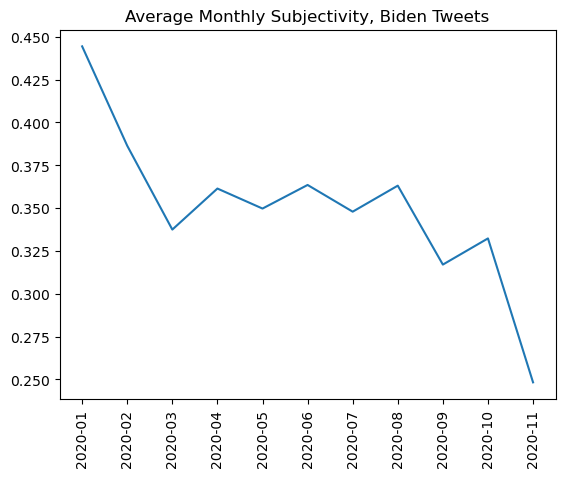

In [21]:
print(biden_monthly_subjectivity)
# create a dictionary with the given data
data = {'timestamp': ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11'], 
        'Average Monthly Subjectivity': [0.444377, 0.386379, 0.337467, 0.361409, 0.349735, 0.363501, 0.347916, 0.363099, 0.317042, 0.332317, 0.248330]}

# create a pandas dataframe from the dictionary
biden_monthly_subjectivity = pd.DataFrame(data)

biden_monthly_subjectivity

import matplotlib.pyplot as plt
x = biden_monthly_subjectivity.timestamp
y = biden_monthly_subjectivity['Average Monthly Subjectivity']

plt.plot(x, y) 
plt.xticks(rotation = 90)
plt.title("Average Monthly Subjectivity, Biden Tweets")

timestamp
2019-12    0.401135
2020-01    0.401566
2020-02    0.477393
2020-03    0.417070
2020-04    0.418571
2020-05    0.417320
2020-06    0.427340
2020-07    0.414512
2020-08    0.324403
2020-09    0.339867
2020-10    0.333972
2020-11    0.351508
2020-12    0.374498
2021-01    0.313011
Freq: M, Name: Subjectivity, dtype: float64


Text(0.5, 1.0, 'Average Monthly Subjectivity, Trump Tweets')

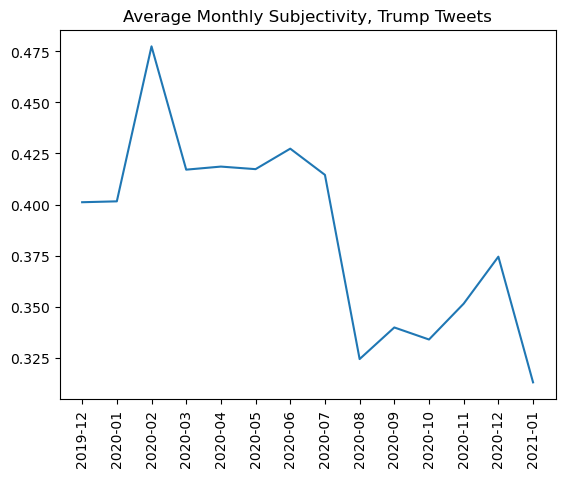

In [22]:
print(trump_monthly_subjectivity)

# create a list with the given data
data = {'timestamp': ['2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01'],
        'Average Monthly Subjectivity': [0.401135, 0.401566, 0.477393, 0.417070, 0.418571, 0.417320, 0.427340, 0.414512, 0.324403, 0.339867, 0.333972, 0.351508, 0.374498, 0.313011]}

# create a pandas dataframe from the dictionary
trump_monthly_subjectivity = pd.DataFrame(data)

trump_monthly_subjectivity

import matplotlib.pyplot as plt
x = trump_monthly_subjectivity.timestamp
y = trump_monthly_subjectivity['Average Monthly Subjectivity']

plt.plot(x, y) 
plt.xticks(rotation = 90)
plt.title("Average Monthly Subjectivity, Trump Tweets")


Text(0.5, 1.0, 'Avgerage Monthly Subjectivity')

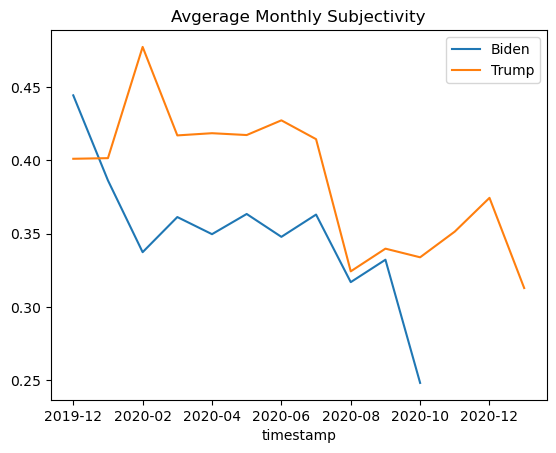

In [23]:
trump_monthly_subjectivity['Person'] = "Trump"
biden_monthly_subjectivity['Person'] = "Biden"
frames = [trump_monthly_subjectivity, biden_monthly_subjectivity]
month_subjectivity = pd.concat(frames)

x = month_subjectivity.timestamp
y = month_subjectivity['Average Monthly Subjectivity']
group = month_subjectivity.Person

month_subjectivity.set_index('timestamp', inplace=True)
month_subjectivity.groupby('Person')['Average Monthly Subjectivity'].plot(legend=True)
plt.title("Avgerage Monthly Subjectivity")

**Polarity Over Time**

   timestamp  Average Monthly Polarity
0    2020-01                  0.118177
1    2020-02                  0.137373
2    2020-03                  0.121206
3    2020-04                  0.120867
4    2020-05                  0.085397
5    2020-06                  0.083252
6    2020-07                  0.093895
7    2020-08                  0.128182
8    2020-09                  0.119819
9    2020-10                  0.112831
10   2020-11                  0.074997


Text(0.5, 1.0, 'Average Monthly Polarity, Biden Tweets')

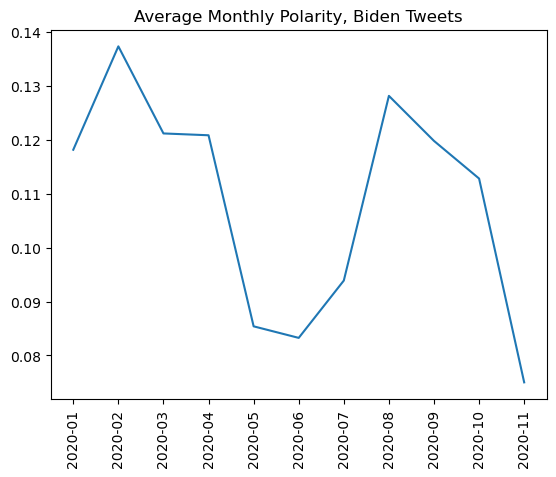

In [24]:
biden_monthly_polarity = biden.groupby(pd.PeriodIndex(biden['timestamp'], freq="M"))['Polarity'].mean() 
trump_monthly_polarity = trump.groupby(pd.PeriodIndex(trump['timestamp'], freq="M"))['Polarity'].mean()

biden_monthly_polarity

# create a list with the given data
data = {'timestamp': ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11'],
        'Average Monthly Polarity': [0.118177, 0.137373, 0.121206, 0.120867, 0.085397, 0.083252, 0.093895, 0.128182, 0.119819, 0.112831, 0.074997]}

# create a pandas dataframe from the dictionary
biden_monthly_polarity = pd.DataFrame(data)

print(biden_monthly_polarity)

x = biden_monthly_polarity.timestamp
y = biden_monthly_polarity['Average Monthly Polarity']

plt.plot(x, y) 
plt.xticks(rotation = 90)
plt.title("Average Monthly Polarity, Biden Tweets")


   timestamp  Average Monthly Polarity
0    2019-12                  0.262635
1    2020-01                  0.155938
2    2020-02                  0.159685
3    2020-03                  0.157565
4    2020-04                  0.136197
5    2020-05                  0.118247
6    2020-06                  0.134773
7    2020-07                  0.109786
8    2020-08                  0.104001
9    2020-09                  0.129617
10   2020-10                  0.118501
11   2020-11                  0.124793
12   2020-12                  0.087523
13   2021-01                  0.120317


Text(0.5, 1.0, 'Average Monthly Polarity, Trump Tweets')

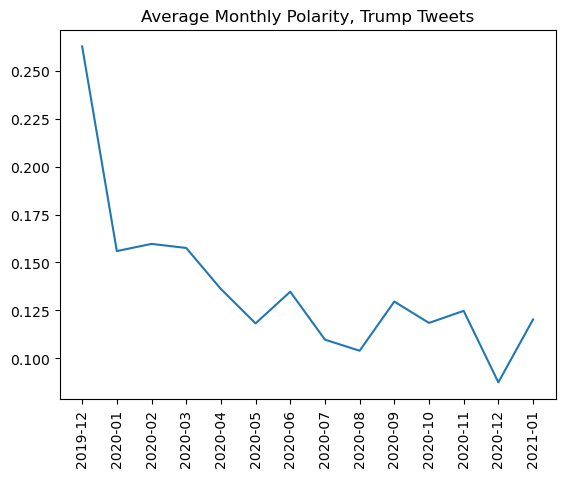

In [25]:
trump_monthly_polarity

# create a list with the given data
data = {'timestamp': ['2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01'],
        'Average Monthly Polarity': [0.262635, 0.155938, 0.159685, 0.157565, 0.136197, 0.118247, 0.134773, 0.109786, 0.104001, 0.129617, 0.118501, 0.124793, 0.087523, 0.120317]}

# create a pandas dataframe from the dictionary
trump_monthly_polarity = pd.DataFrame(data)

print(trump_monthly_polarity)

x = trump_monthly_polarity.timestamp
y = trump_monthly_polarity['Average Monthly Polarity']

plt.plot(x, y) 
plt.xticks(rotation = 90)
plt.title("Average Monthly Polarity, Trump Tweets")



Text(0.5, 1.0, 'Average Monthly Polarity')

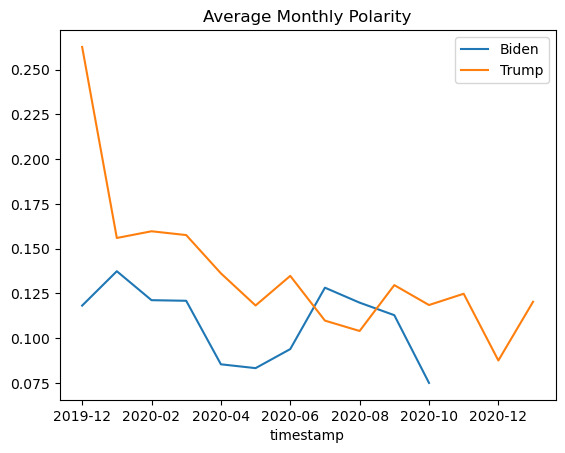

In [26]:
trump_monthly_polarity['Person'] = "Trump"
biden_monthly_polarity['Person'] = "Biden"
frames = [trump_monthly_polarity, biden_monthly_polarity]
month_polarity = pd.concat(frames)

x = month_polarity.timestamp
y = month_polarity['Average Monthly Polarity']
group = month_polarity.Person

month_polarity.set_index('timestamp', inplace=True)
month_polarity.groupby('Person')['Average Monthly Polarity'].plot(legend=True)
plt.title("Average Monthly Polarity")